## CREATE AND CUT THE GRAPH

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install leidenalg==0.7.0
# conda install -c conda-forge graph-tool

In [3]:
%matplotlib inline
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time

## Import files

In [124]:
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL.pt" 
mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v2.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_LARGE.pt" 

tiling = torch.load(mask_file, map_location=torch.device('cpu'))

# PRINT SOME STUFF
for f in tiling._fields:
    print(f,"-->",getattr(tiling, f).shape)
print(mask_file)

co_object --> torch.Size([36, 100, 100])
raw_img --> torch.Size([1, 100, 100])
integer_mask --> torch.Size([1, 100, 100])
/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v2.pt


In [125]:
g_old = GraphSegmentation(tiling)

radius_nn -> 5
ch_e_ii --> 0
n_fg_pixel --> 3214


In [126]:
g_old.clusters.summary()

computing connected clusters
--- clustering time 0.002689838409423828 ---


'Clustering with 3214 elements and 12 clusters'

In [127]:
for c in g_old.clusters:
    print(len(c))

90
645
49
301
175
166
170
126
909
180
313
90


In [128]:
sub_g_old = g_old.graph.subgraph(g_old.clusters[8])
ig.plot(sub_g_old)

# This is the new tool

In [129]:
adj = g_old._build_adjacency()
#adj

In [143]:
import graph_tool 
import graph_tool.draw
ug = graph_tool.Graph(directed=False)
eweight = ug.new_edge_property("float")
#edge_list = [ (i,j,-numpy.log(1-w)) for i,j,w in zip(adj.source, adj.destination, adj.edge_weight)]
edge_list = [ (i,j,float(w)/64) for i,j,w in zip(adj.source, adj.destination, adj.edge_weight)]
ug.add_edge_list(edge_list, eprops=[eweight])
ug.ep["weight"] = eweight

In [145]:
edge_list[:10]

[(1, 0, 0.046875),
 (2, 1, 0.78125),
 (3, 2, 0.984375),
 (4, 3, 0.984375),
 (5, 4, 0.984375),
 (6, 5, 0.984375),
 (7, 6, 0.984375),
 (8, 7, 0.984375),
 (9, 8, 0.859375),
 (10, 9, 0.859375)]

In [146]:
#adj.edge_weight

In [147]:
ug.ep

{'weight': <EdgePropertyMap object with value type 'double', for Graph 0x7f84dead7520, at 0x7f84dead7100>}

In [148]:
#for e in ug.edges():
#    print(e,eweight[e])

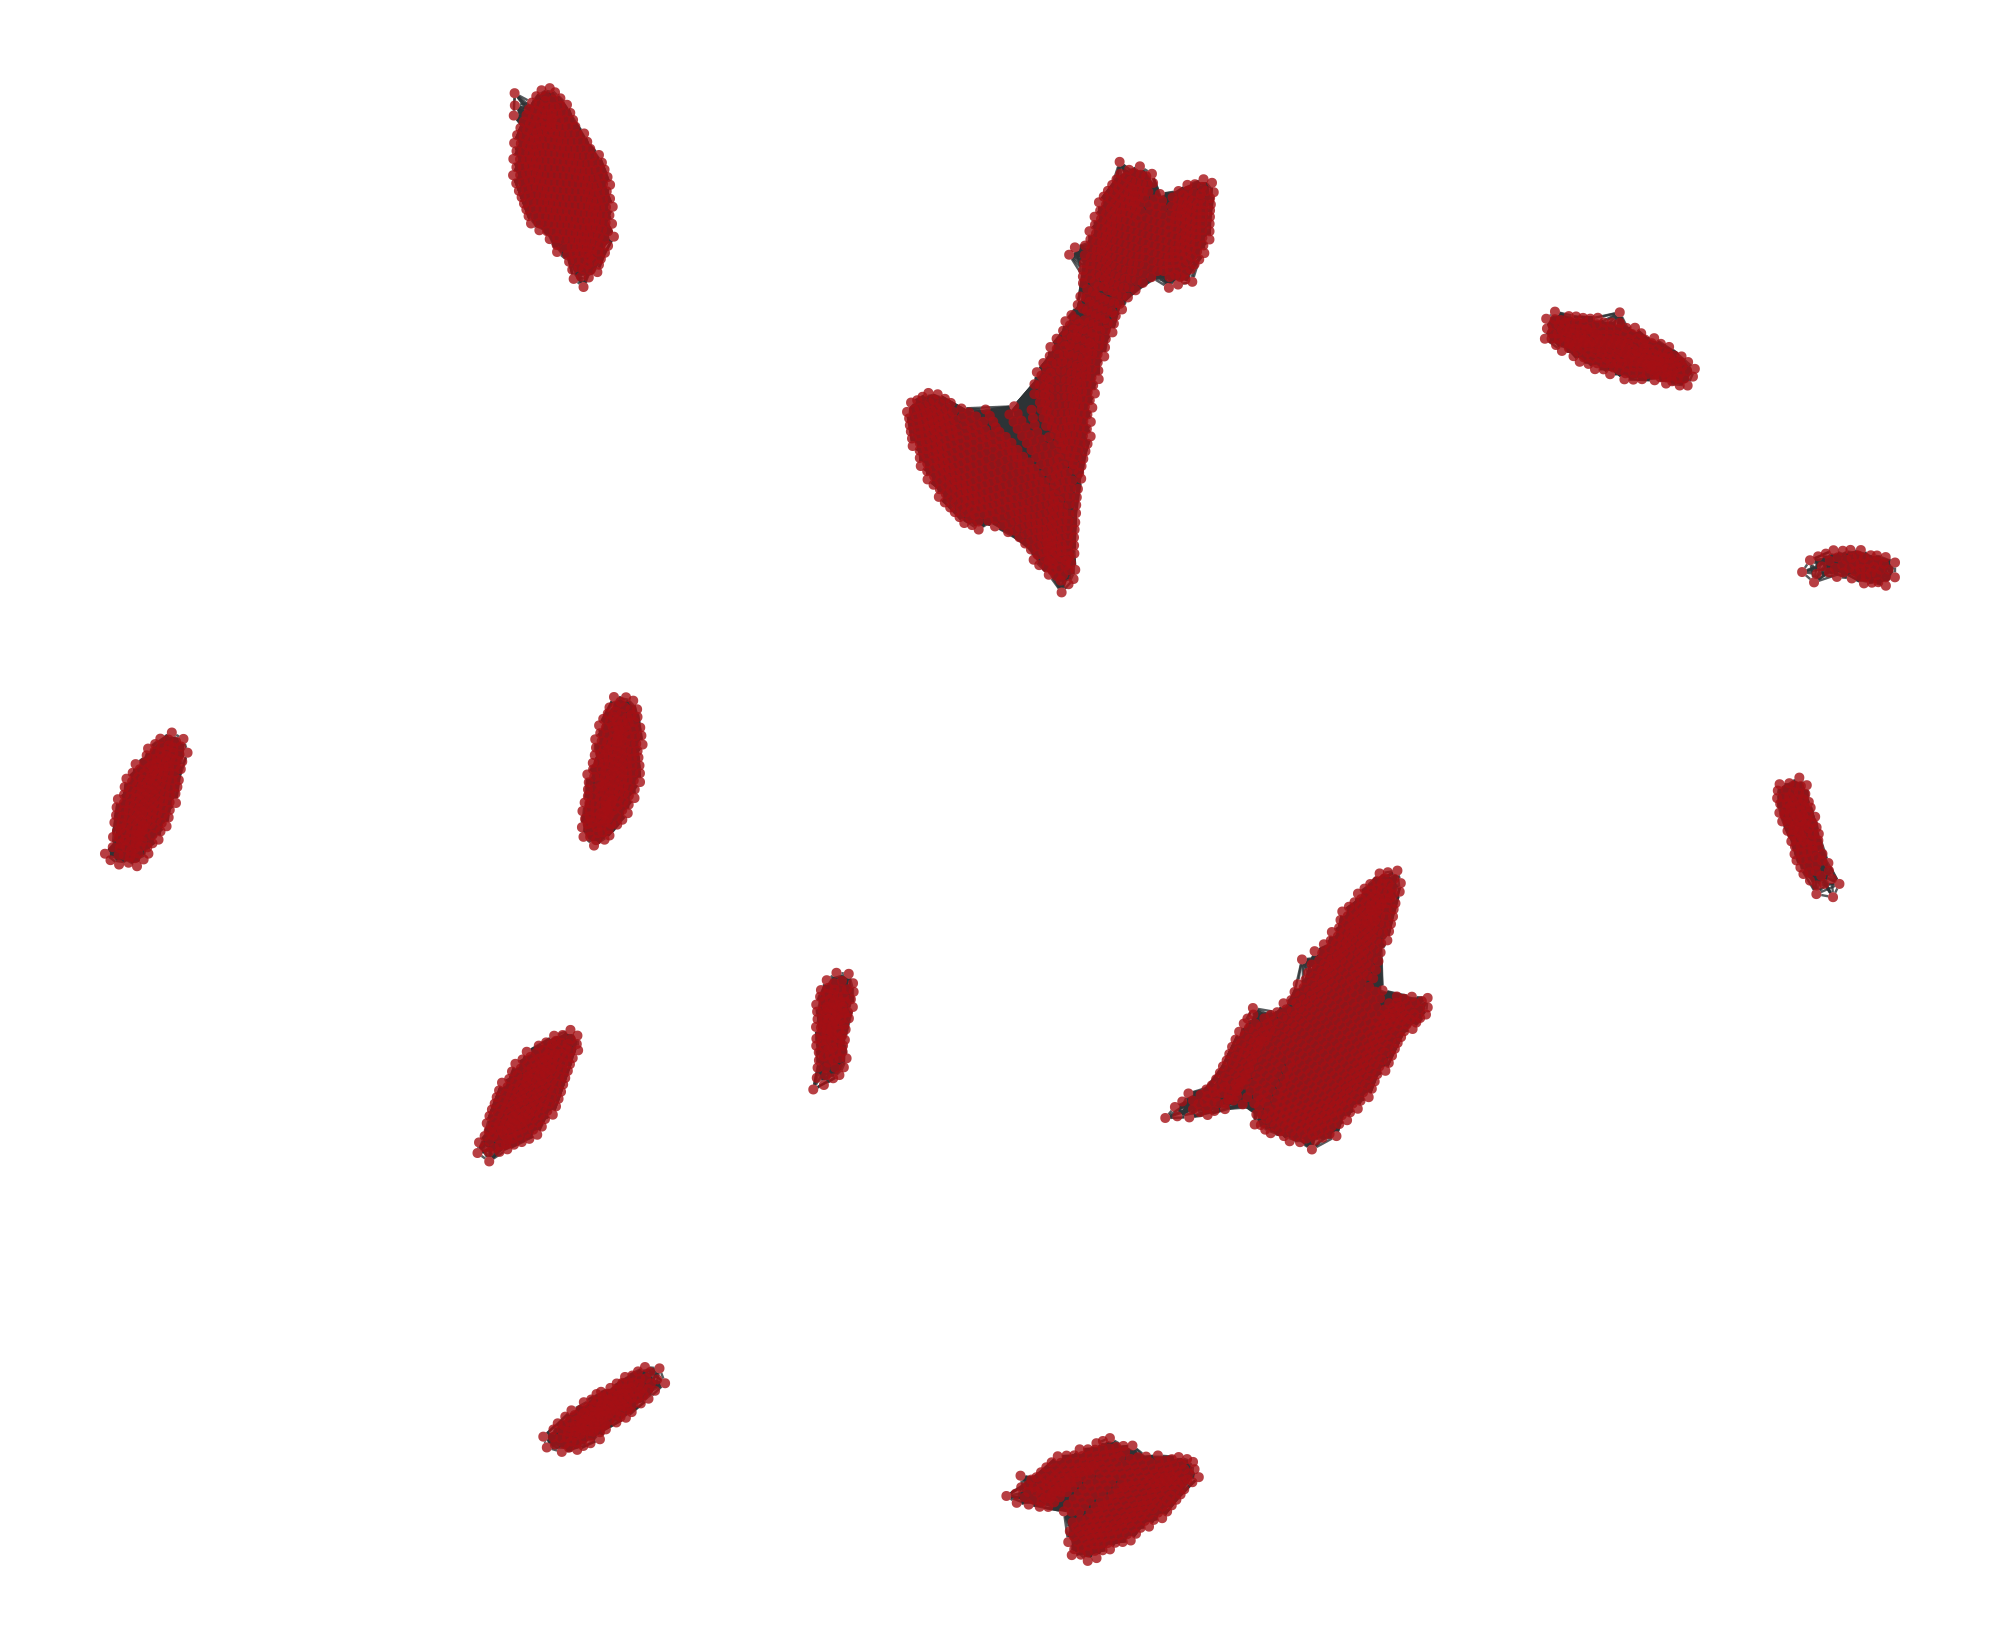

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84dead7520, at 0x7f84e18005b0>

In [149]:
pos = graph_tool.draw.sfdp_layout(ug)
graph_tool.draw.graph_draw(ug, pos, output_size=(1000, 1000), vertex_color=[1,1,1,0],
                           vertex_size=5, edge_pen_width=1.2,
                           vcmap=matplotlib.cm.gist_heat_r)

In [150]:
state_ndc = graph_tool.inference.minimize_nested_blockmodel_dl(ug, 
                                                               deg_corr=True,
                                                               state_args=dict(recs=[ug.ep.weight], 
                                                                               rec_types=["discrete-geometric"]))

In [151]:
state_ndc.print_summary()

l: 0, N: 3214, B: 202
l: 1, N: 202, B: 56
l: 2, N: 56, B: 17
l: 3, N: 17, B: 6
l: 4, N: 6, B: 2
l: 5, N: 2, B: 1


In [152]:
def derive_partition_from_level(graph, levels, n):
    m = [v for v in graph.vertices()]
    for l in range(0, n+1):
        m = [ levels[l].get_blocks()[r] for r in m]
    return m

In [157]:
membership = derive_partition_from_level(ug, state_ndc.get_levels(), n=1)
sizes = numpy.bincount(membership)
partition = SimplifiedPartition(sizes=sizes,
                                membership=membership,
                                resolution_parameter=0,
                                modularity=0)


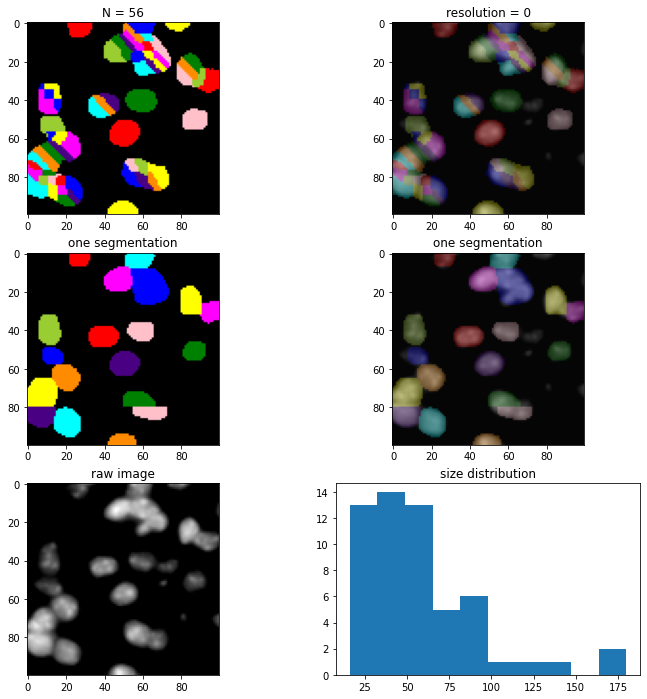

In [158]:
c = g_old.partition_2_community(partition, size_threshold=10)
g_old.plot_community(c, figsize=(12,12))

In [118]:
numpy.bincount(membership)

array([167, 100, 214,  80,  44,  25,  77, 102,  57,  26,  52, 157,  60,
        42,  86, 143, 167, 117, 172, 172, 108,  56,  78,  40,  66,  94,
        54,  40, 108,  50,  26,  24, 111,  77,  64])

In [107]:
levels = state_ndc.get_levels()

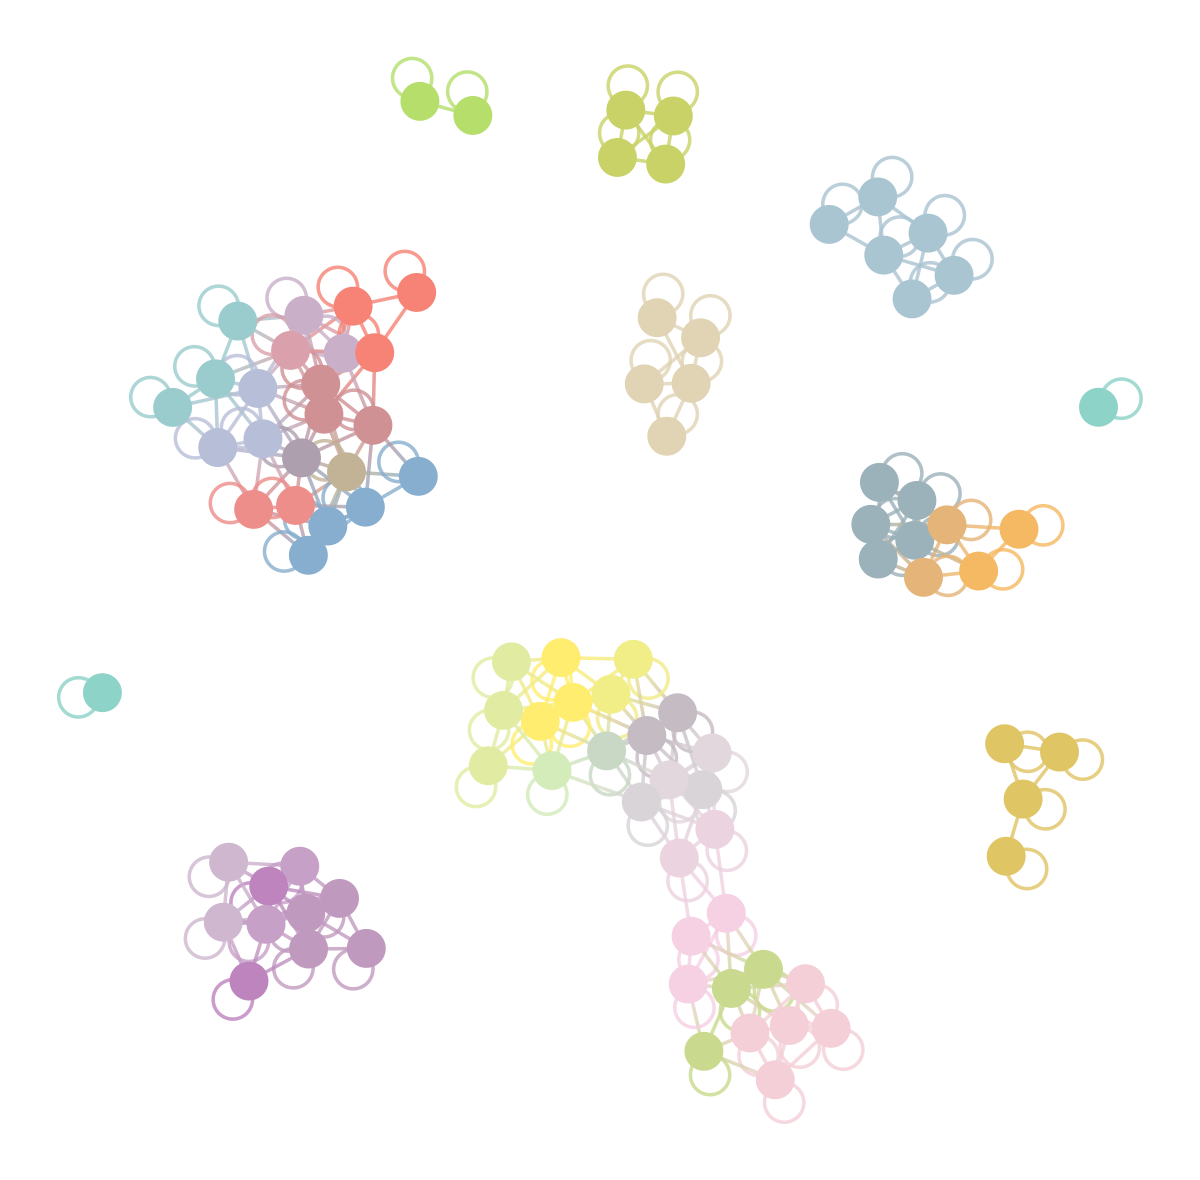

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8522b34f70, at 0x7f84e1f75670>

In [113]:
levels[2].draw()

In [ ]:

graph_tool.draw.graph_draw(ug, pos, output_size=(1000, 1000), vertex_color=[1,1,1,0],
                           vertex_size=5, edge_pen_width=1.2,
                           vcmap=matplotlib.cm.gist_heat_r)



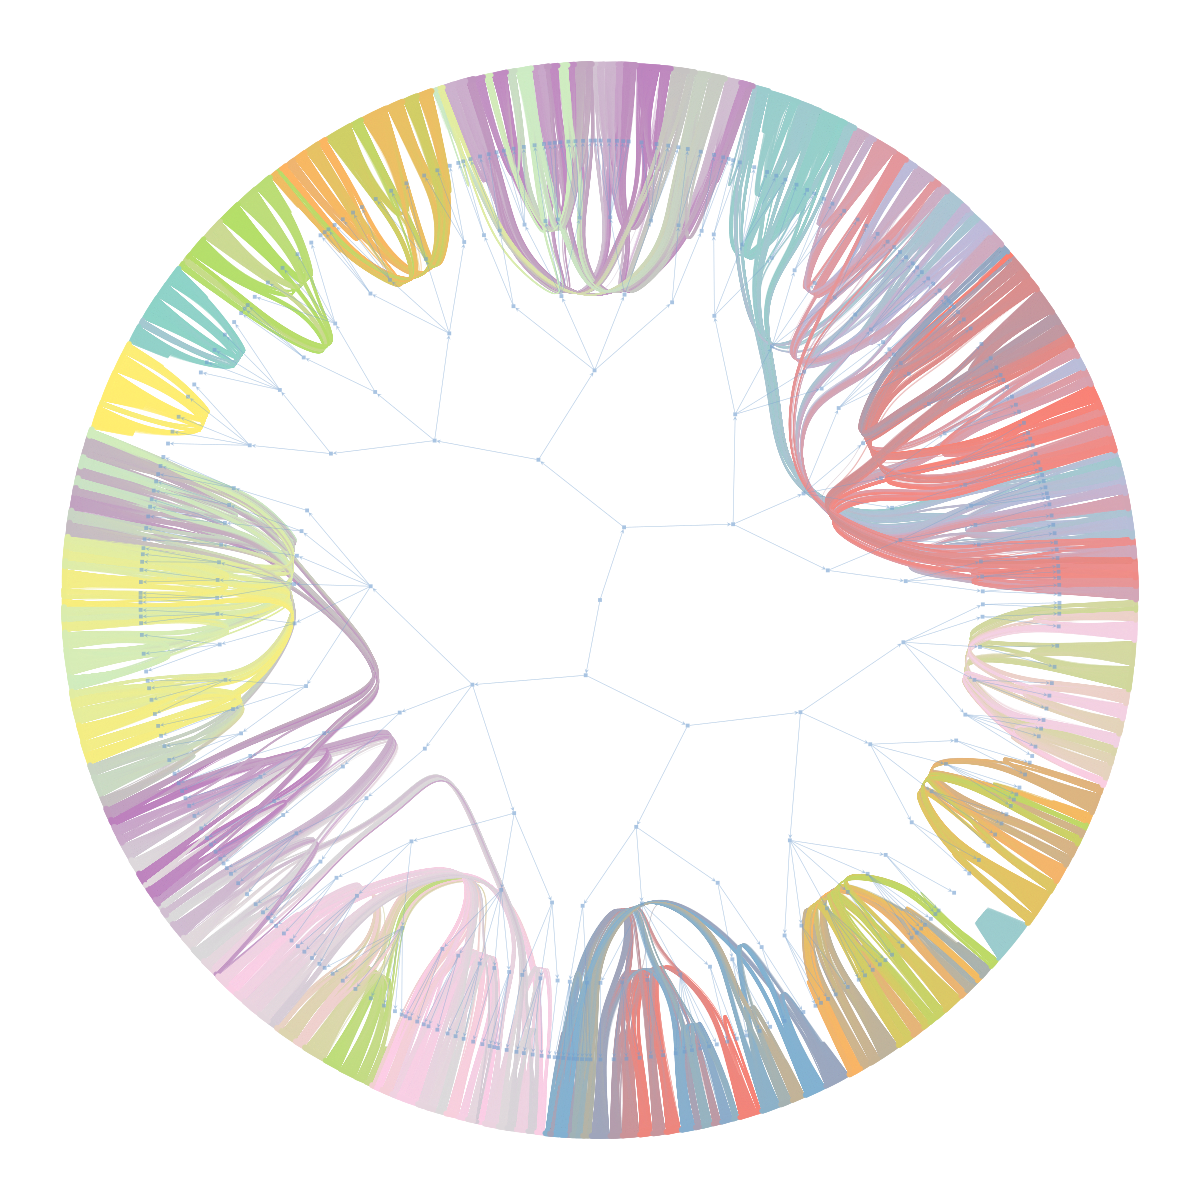

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84e148aeb0, at 0x7f850be05640>,
 <Graph object, directed, with 3493 vertices and 3492 edges, at 0x7f84eacabfd0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84eacabfd0, at 0x7f84e1f5aeb0>)

In [105]:
state_ndc.draw()

In [96]:
state_ndc.print_summary()

l: 0, N: 3056, B: 271
l: 1, N: 271, B: 85
l: 2, N: 85, B: 31
l: 3, N: 31, B: 14
l: 4, N: 14, B: 4
l: 5, N: 4, B: 2
l: 6, N: 2, B: 1


In [98]:
levels = state_ndc.get_levels()
for s in levels:
    print(s)

<BlockState object with 271 blocks (271 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 3056 vertices and 75700 edges, 1 internal edge property, at 0x7f84e148aeb0>, at 0x7f84e2866490>
<BlockState object with 85 blocks (85 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 271 vertices and 1726 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f84e1e5d580>, at 0x7f84e1e64bb0>
<BlockState object with 31 blocks (31 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 85 vertices and 297 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f84e1e644f0>, at 0x7f84e1e40d90>
<BlockState object with 14 blocks (14 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 31 vertices and 70 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f84d9aa67f0>, at 0x7f84e1e4dd90>
<BlockState object with 4 blocks (4 nonempty), with 1 edge covariate, for graph

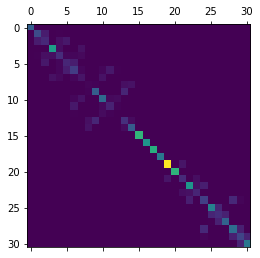

In [99]:
e = levels[2].get_matrix()
plt.matshow(e.todense())

In [102]:
membership = [ levels[0].get_blocks()[v] for v in ug.vertices()]
sizes = numpy.bincount(membership)

In [103]:
sizes

array([26, 19, 16, 14, 12, 14, 19, 17, 21, 21, 13, 10,  6,  7,  4,  7,  4,
        5, 14, 15,  5,  4,  6,  6,  4,  9,  8, 16, 18, 10,  8,  6,  9,  9,
        8,  9,  9, 13, 13, 21,  9, 11,  8,  9, 18, 10,  9, 10, 12,  9,  6,
        9,  9, 16,  2, 16, 12, 10,  7, 15, 16,  9,  7, 12,  6, 19, 17, 27,
       13,  6,  6, 14, 14,  7,  3,  6, 16,  8, 20, 15,  8, 11, 11,  7,  8,
       19,  6, 10,  6,  4, 16, 11, 21,  9,  7, 17, 12, 15, 10, 17, 14, 18,
        8, 12,  9, 10, 15,  8,  6,  8, 10, 19,  8,  8, 11,  9,  7,  7,  9,
       19, 10,  9, 26, 13, 24, 18,  8,  9,  8,  8, 11,  9,  7,  9,  3,  4,
       21, 19,  6, 18, 20, 11, 14, 10,  6, 23, 20,  9,  4, 24, 27,  6, 11,
       11, 12, 15,  7, 17, 15,  9,  6,  7,  8,  6,  6,  9,  7, 15,  5, 14,
       17, 18, 14, 11,  6,  6, 19,  7, 18, 10, 10, 16, 16,  9, 10, 10,  7,
       14, 16, 16,  6, 14,  7, 13, 15, 11, 10, 11,  9, 10, 12, 11, 16,  5,
       10,  5, 12, 17, 14, 10,  9, 10, 12, 17,  9,  6,  8, 10,  7, 11, 15,
        8, 12, 12,  9,  6

In [ ]:
membership

In [ ]:
e = levels[2].get_matrix()
plt.matshow(e.todense())

In [ ]:
state.

In [ ]:
state.draw(pos=pos)

In [ ]:
type(edge_list)

In [ ]:
edge_list[:10]

In [ ]:
edge_list = [(0, 1, .3, 10), (2, 3, .1, 0), (2, 0, .4, 42)]

g = gt.Graph()
eweight = g.new_ep("double")
elayer = g.new_ep("int")
g.add_edge_list(edge_list, eprops=[eweight, elayer])

In [ ]:
_ = ug.add_vertex(n=g_old.n_fg_pixel)
for i,j,w in zip(adj.source, adj.destination, adj.edge_weight):
    
    print(i,j,w)

In [ ]:
for n in range(g_old.n_fg_pixel):
    v = ug.add_vertex()
    v_label[v] = n
    print(v,n)

In [ ]:
for v in ug.vertices():
    print(v)
#for e in g.edges():
#    print(e)

In [ ]:
for i,j,w in zip(adj.source, adj.destination, adj.edge_weight):
    print(i,j,w)
    

In [ ]:

pos = sfdp_layout(ug)
graph_draw(ug, pos, output_size=(1000, 1000), vertex_color=[1,1,1,0],
           vertex_fill_color=v_label, vertex_size=10, edge_pen_width=1.2,
           vcmap=matplotlib.cm.gist_heat_r, output="price.pdf")



In [ ]:
g_old.adj 

In [ ]:
for i in range(1, N):
    # create our new vertex
    v = g.add_vertex()
    v_age[v] = i

    # we need to sample a new vertex to be the target, based on its in-degree +
    # 1. For that, we simply randomly sample it from vlist.
    i = randint(0, len(vlist))
    target = vlist[i]

    # add edge
    e = g.add_edge(v, target)

In [ ]:
for i in range(1, N):
    # create our new vertex
    v = g.add_vertex()
    v_age[v] = i

    # we need to sample a new vertex to be the target, based on its in-degree +
    # 1. For that, we simply randomly sample it from vlist.
    i = randint(0, len(vlist))
    target = vlist[i]

    # add edge
    e = g.add_edge(v, target)

In [ ]:
plt.imshow(tiling.raw_img[0], cmap='gray')

In [ ]:
g = GraphSegmentation(tiling)

In [ ]:
ig.plot(g.graph)

In [ ]:
g.clusters.summary()

In [ ]:
c0 = g.partition_2_community(g.clusters)
g.plot_community(c0, figsize=(12,12), density=False)

In [ ]:
plt.imshow(c0.mask)

In [ ]:
plot_grid(tiling.co_object, figsize=(12,12))

In [ ]:
start_time = time.time()
p1 = g.find_partition(resolution=8.0, each_connected_component_separately=False)
c1 = g.partition_2_community(p1)
print("--- comminity all together %s ---" % (time.time() - start_time))
g.plot_community(c1, figsize=(12,12), density=False, range=(10,300), bins=50) #, windows=[1000,1100,2000,2100])

In [ ]:
start_time = time.time()
p2 = g.find_partition(resolution=0.01, each_connected_component_separately=True)
c2 = g.partition_2_community(p2)
print("--- comminity separately %s ---" % (time.time() - start_time))
g.plot_community(c2, figsize=(12,12), density=False, range=(10,300), bins=50, windows=[1000,1100,2000,2100])

# Connected Components

In [ ]:
g = GraphSegmentation(tiling)

In [ ]:
start_time = time.time()
c=g.partition_2_community(g.clusters)
end_time = time.time()
print("--- partition_2_community %s ---" % (end_time  - start_time))
g.plot_community(c, figsize=(12,12), density=True, range=(10,1000))

# Community detection

In [ ]:
start_time = time.time()
partition = g.find_partition(resolution=0.1, initial=False)
mid_time = time.time()
print("--- compute partitions %s ---" % (mid_time - start_time))
community = g.partition_2_community(partition, size_threshold=10)
end_time = time.time()
print("--- partition_2_community %s ---" % (end_time  - mid_time))
g.plot_community(community, figsize=(12, 12), density=True, bins=50, range=(10,1000))

In [ ]:
# MAKE A GRASPH FOR EACH CONNECTED COMPONENTS...

In [ ]:
p = g.find_partition(resolution=0.3, each_cluster=False)

In [ ]:
resolution = [0.01, 0.1, 0.2, 0.3, 0.5]

In [ ]:
g.clusters.summary()

In [ ]:
g.graph.summary()

In [ ]:
import igraph as ig


In [ ]:
ig.subgraph(g, v)

In [ ]:
a = g.clusters.subgraphs()

In [ ]:
len(a)

In [ ]:
ig.plot(a[0])

In [ ]:
g.find_partition()

In [ ]:
a[0].summary()

In [ ]:
a[0].summary()
a[0].

In [ ]:
print(type(a))

In [ ]:
g.clusters.summary()


In [ ]:
g.graph.subgraph(g,v)

In [ ]:
figure, axes = plt.subplots(ncols=3, figsize=(12,12))
axes[0].imshow(c.mask==2)
axes[1].imshow(c.mask==12)
axes[2].imshow(c.mask==9)

### Analyze the graph all at once

In [ ]:
partition = g_small.find_partition(resolution=0.1)
community = g_small.partition_2_community(partition, size_threshold=10)
g_small.plot_community(community, figsize=(20,20))

In [ ]:
partition = g_small.find_partition(resolution=0.3)
community = g_small.partition_2_community(partition, size_threshold=10)
g_small.plot_community(community, figsize=(20,20))

In [ ]:
partition = g_small.find_partition(resolution=0.35)
community = g_small.partition_2_community(partition, size_threshold=10)
g_small.plot_community(community, figsize=(20,20))

# MAKE PLOT OF RESOLUTION PARAMETER VS N_OBJECT

In [ ]:
asser 1==2

In [ ]:
print(community.n)
ncols, max_row = 5,5
figure, axes = plt.subplots(ncols=ncols, nrows=max_row, figsize=(20,20))
for n in range(community.n):
    row = n//ncols
    col = n % ncols
    axes[row, col].imshow(community.mask == n)

print(community.n)
ncols, max_row = 5,5
figure, axes = plt.subplots(ncols=ncols, nrows=max_row, figsize=figsize)
for n in range(community.n):
    row = n//ncols
    col = n % ncols
    axes[row, col].imshow(community.mask == n)

In [ ]:
plt.imshow(community.mask ==)

In [ ]:
partition = g_small.find_partition(resolution=0.04)
community = g_small.partition_2_community(partition, size_threshold=10)

In [ ]:
print(community.n)
g_small.plot_community(community, figsize=(20,20))

In [ ]:
plot_grid(tiles.co_objectiveness, figsize=(20,20))

## Find connected components

In [ ]:
partition = g_small.graph.clusters(mode="STRONG")
c=g_small.partition_2_community(partition)
g_small.plot_community(c, figsize=(20,20))

In [ ]:
numpy.max(c.mask)

In [ ]:
plt.imshow(c.mask==10)

In [ ]:
c.n

In [ ]:
plt.imshow(c.mask)

In [ ]:
profile = g_small.find_profile(resolution_range=(0.01,0.5))

In [ ]:
masks = g_small.profile_2_seg_masks(profile, size_threshold=10)
g_small.plot_seg_masks(masks, ncols=4, figsize=(20,20))

In [ ]:
profile[0].

In [ ]:
profile

In [ ]:
G = ig.Graph.Famous('Zachary')
optimiser = la.Optimiser()
profile_z = optimiser.resolution_profile(G, la.CPMVertexPartition,
                                       resolution_range=(0,1))

In [ ]:
for partition in profile_z:
    print(partition.modularity, partition.resolution_parameter)
    
numpy.sum(numpy.array(profile_z[4].sizes()) > 10)

In [ ]:
numpy.sum(numpy.array(profile_z[4].sizes()) > 10)


In [ ]:
profile_z[4].resolution_parameter